In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import time
from datetime import timedelta
from IPython.display import clear_output

import gymnasium as gym

import torch
import torch.nn as nn

from  td3 import ReplayBuffer, TD3

In [2]:
def eval_policy(env_name, agent, seed, eval_episodes=5):
    env = gym.make(env_name)
        
    avg_return = 0.
    for _ in range(eval_episodes):
        obs, info = env.reset(seed=seed)
        done = False
        while not done:
            action = agent.get_action(torch.as_tensor(obs, dtype=torch.float32), action_noise=0)
            obs, reward, terminated, truncated, _ = env.step(action)
            avg_return += reward
            done = terminated or truncated
            
    avg_return /= eval_episodes
    
    print("---------------------------------------")
    print(f"Evaluation over {eval_episodes} episodes, average return: {avg_return:.3f}")
    print("---------------------------------------")
    env.close()
    return avg_return

In [3]:
class Config(object):
    def __init__(self):
        pass

config = Config()
config.capacity = int(1e6)       # Maximum size of replay buffer.
config.gamma = 0.99              # Discount factor.
# config.max_ep_len = 1000         # Maximum length of trajectory / episode / rollout.
config.action_noise = 0.1        # Stddev for Gaussian exploration noise added to policy at training time when agent interacts with env. (At test time, no noise is added.)
config.target_noise = 0.2        # Stddev for smoothing noise added to target policy at training time when computing target Q-values. (At test time, no noise is added.)
config.noise_clip = 0.5          # Limit for absolute value of target policy smoothing noise.


config.actor_hiddens = (64, 64)  # network architecture for actor.
config.critic_hiddens = (64, 64) # network architecture for critic.
config.activation = nn.ReLU      # activation function for actor and critic.
config.rho = 0.995               # polyak averaging hyperparm for target network update: \theta_{targ} \leftarrow \rho \theta_{targ} + (1-\rho) \theta
config.actor_lr = 1e-3           # Learning rate for actor optimizer.
config.critic_lr = 1e-3          # Learning rate for critic optimizer.
config.policy_delay = 2          # Policy will only be updated once every policy_delay times for each update of the Q-networks.

config.batch_size = 64           # Minibatch size for SGD.
config.max_timesteps = 50000     # Maximum number of steps of interaction (state-action pairs) for the agent and the environment.
config.start_timesteps = 10000       # Number of steps for uniform-random action getion, before running real policy. Helps exploration.
config.update_after = 1000       # Number of env interactions to collect before starting to do gradient descent updates. Ensures replay buffer is full enough for useful updates.
config.update_every = 1000       # Number of env interactions that should elapse between gradient descent updates. Note: Regardless of how long you wait between updates, the ratio of env steps to gradient steps is locked to 1. 其实设置成1就可以了。
config.eval_freq = 5000          # How often (time steps) we evaluate land save the model.

# Training

In [4]:
start = time.time()

env_name = 'HalfCheetah-v4'     # CartPole-v1, LunarLander-v2
seed = 3 


file_name = f'TD3_{env_name}_{seed}'
print('--------------------------------------')
print(f'Policy: TD3, Env: {env_name}, Seed: {seed}')
print('--------------------------------------')

# set seed
torch.manual_seed(seed)       
np.random.seed(seed)
random.seed(seed)

env = gym.make(env_name)
obs_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# initialize agent and replay buffer
td3_agent = TD3(obs_dim, action_dim, max_action, config=config)
buffer = ReplayBuffer(obs_dim, action_dim, config.capacity)


# evaluate untrained policy
evaluations = [eval_policy(env_name, td3_agent, seed)]

obs, info = env.reset(seed=seed)
episode_return = 0
episode_timesteps = 0
episode_num = 0
running_returns = []


for t in range(int(config.max_timesteps)):
    
    episode_timesteps += 1
    
    # get action randomly or according to policy
    if t < config.start_timesteps:
        action = env.action_space.sample()    # 由于这个sample的随机性，导致buffer中的数据每次训练不一致，从而整个结果是不可复现的
    else:
        action = td3_agent.get_action(torch.as_tensor(obs, dtype=torch.float32), config.action_noise * max_action)  # scale the noise
        
    # perform action
    next_obs, reward, terminated, truncated, _ = env.step(action)
    
    done = terminated or truncated
    
    # store data in replay buffer
    buffer.add(obs, action, next_obs, reward, terminated)  # 注意这里，我们只考虑agent正常结束作为True, 到达最大max_ep_len (truncated)算False
    
    obs = next_obs
    episode_return += reward
           
        
    if done:
        # +1 to account for 0 indexing. +0 on episode_timesteps since it will increment +1 even if done=True
        print(f'Total T: {t+1}---Episode Num: {episode_num+1}---Episode T: {episode_timesteps} Reward: {episode_return:.3f}')
        # reset environment
        obs, info = env.reset(seed=seed)
        running_returns.append(episode_return)
        episode_return = 0
        episode_timesteps = 0
        episode_num += 1
        
    
    # train agent after collecting sufficient data
    if t >= config.update_after and t % config.update_every == 0:
        for _ in range(config.update_every):
            td3_agent.train(buffer, config.batch_size)
        
    
    
    # evaluate episode
    if (t+1) % config.eval_freq == 0:
        evaluations.append(eval_policy(env_name, td3_agent, seed))
        np.save(f'./results/{file_name}', evaluations)
        td3_agent.save(f'./models/{file_name}')

print(timedelta(seconds=int(time.time() - start)))

--------------------------------------
Policy: TD3, Env: HalfCheetah-v4, Seed: 3
--------------------------------------
---------------------------------------
Evaluation over 5 episodes, average return: -0.247
---------------------------------------
Total T: 1000---Episode Num: 1---Episode T: 1000 Reward: -237.961
Total T: 2000---Episode Num: 2---Episode T: 1000 Reward: -232.675
Total T: 3000---Episode Num: 3---Episode T: 1000 Reward: -281.318
Total T: 4000---Episode Num: 4---Episode T: 1000 Reward: -344.588
Total T: 5000---Episode Num: 5---Episode T: 1000 Reward: -409.376
---------------------------------------
Evaluation over 5 episodes, average return: -560.648
---------------------------------------
Total T: 6000---Episode Num: 6---Episode T: 1000 Reward: -209.053
Total T: 7000---Episode Num: 7---Episode T: 1000 Reward: -229.915
Total T: 8000---Episode Num: 8---Episode T: 1000 Reward: -246.945
Total T: 9000---Episode Num: 9---Episode T: 1000 Reward: -158.745
Total T: 10000---Episo

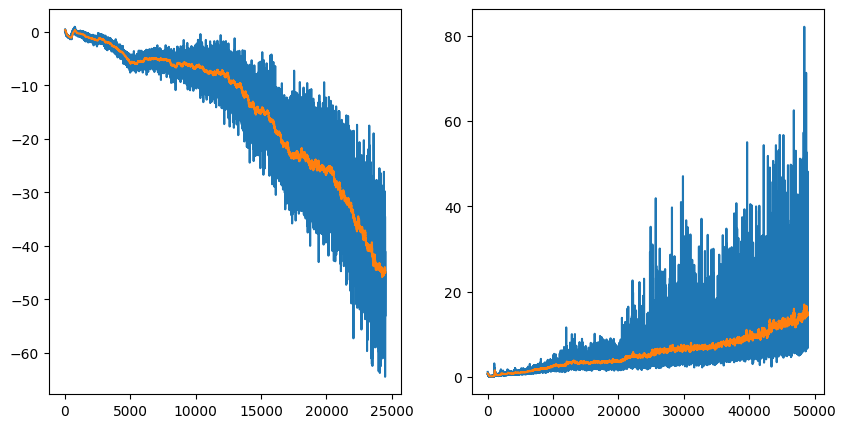

In [5]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(td3_agent.actor_losses)
plt.plot(pd.Series(td3_agent.actor_losses).rolling(100, 20).mean())
plt.subplot(122)
plt.plot(td3_agent.critic_losses)
plt.plot(pd.Series(td3_agent.critic_losses).rolling(100, 20).mean())

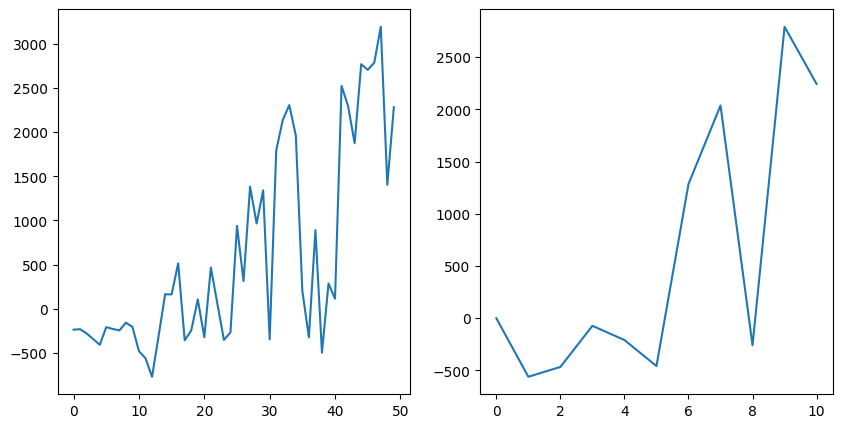

In [6]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(running_returns)
plt.subplot(122)
plt.plot(evaluations)

In [7]:
def render(env_name, agent, seed=None):
    env = gym.make(env_name, render_mode='human')
    obs, info = env.reset(seed=seed)

    returns = 0
    for i in range(1000):
        action = agent.get_action(torch.as_tensor(obs, dtype=torch.float32), action_noise=0)
        obs, reward, terminated, truncated, _ = env.step(action)
        returns += reward
        done = terminated or truncated
        if done:
            print(returns)
            break
    env.close()

In [10]:
render(env_name, td3_agent)

679.1193688778826
